In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from epitools import get_data
from scipy.stats import pearsonr

In [45]:
geography_id = "region_id"
country = "Chile"
output = []
# [2002, 2007, 2012, 2017, 2022]
for year in [2013, 2017, 2021]:

    df_1r = get_data(
        country=country,
        aggregation=geography_id,
        election="first_round",
        year=year
    )

    df_2r = get_data(
        country=country,
        aggregation=geography_id,
        election="runoff",
        year=year
    )

    df = pd.merge(df_1r, df_2r, on=[geography_id, "year"])

    data = df.copy()
    if country == "France":
        data = data[~data["department_id"].str.contains("Z")]
    for col in ["epi", "epi_between", "epi_within"]:
        data[f"{col}_x"] = (data[f"{col}_x"] - data[f"{col}_x"].mean()) / data[f"{col}_x"].std()
        data[f"{col}_y"] = (data[f"{col}_y"] - data[f"{col}_y"].mean()) / data[f"{col}_y"].std()

    data = data.melt(id_vars=[geography_id, "year"])
    data["type"] = data["variable"].str.replace("_x", "").str.replace("_y", "")
    data["variable"] = data["variable"].str.replace("epi_", "").str.replace("within_", "").str.replace("between_", "")

    data = data.pivot(index=[geography_id, "year", "type"], columns=["variable"], values="value").reset_index()
    output.append(data)

data = pd.concat(output, ignore_index=True)


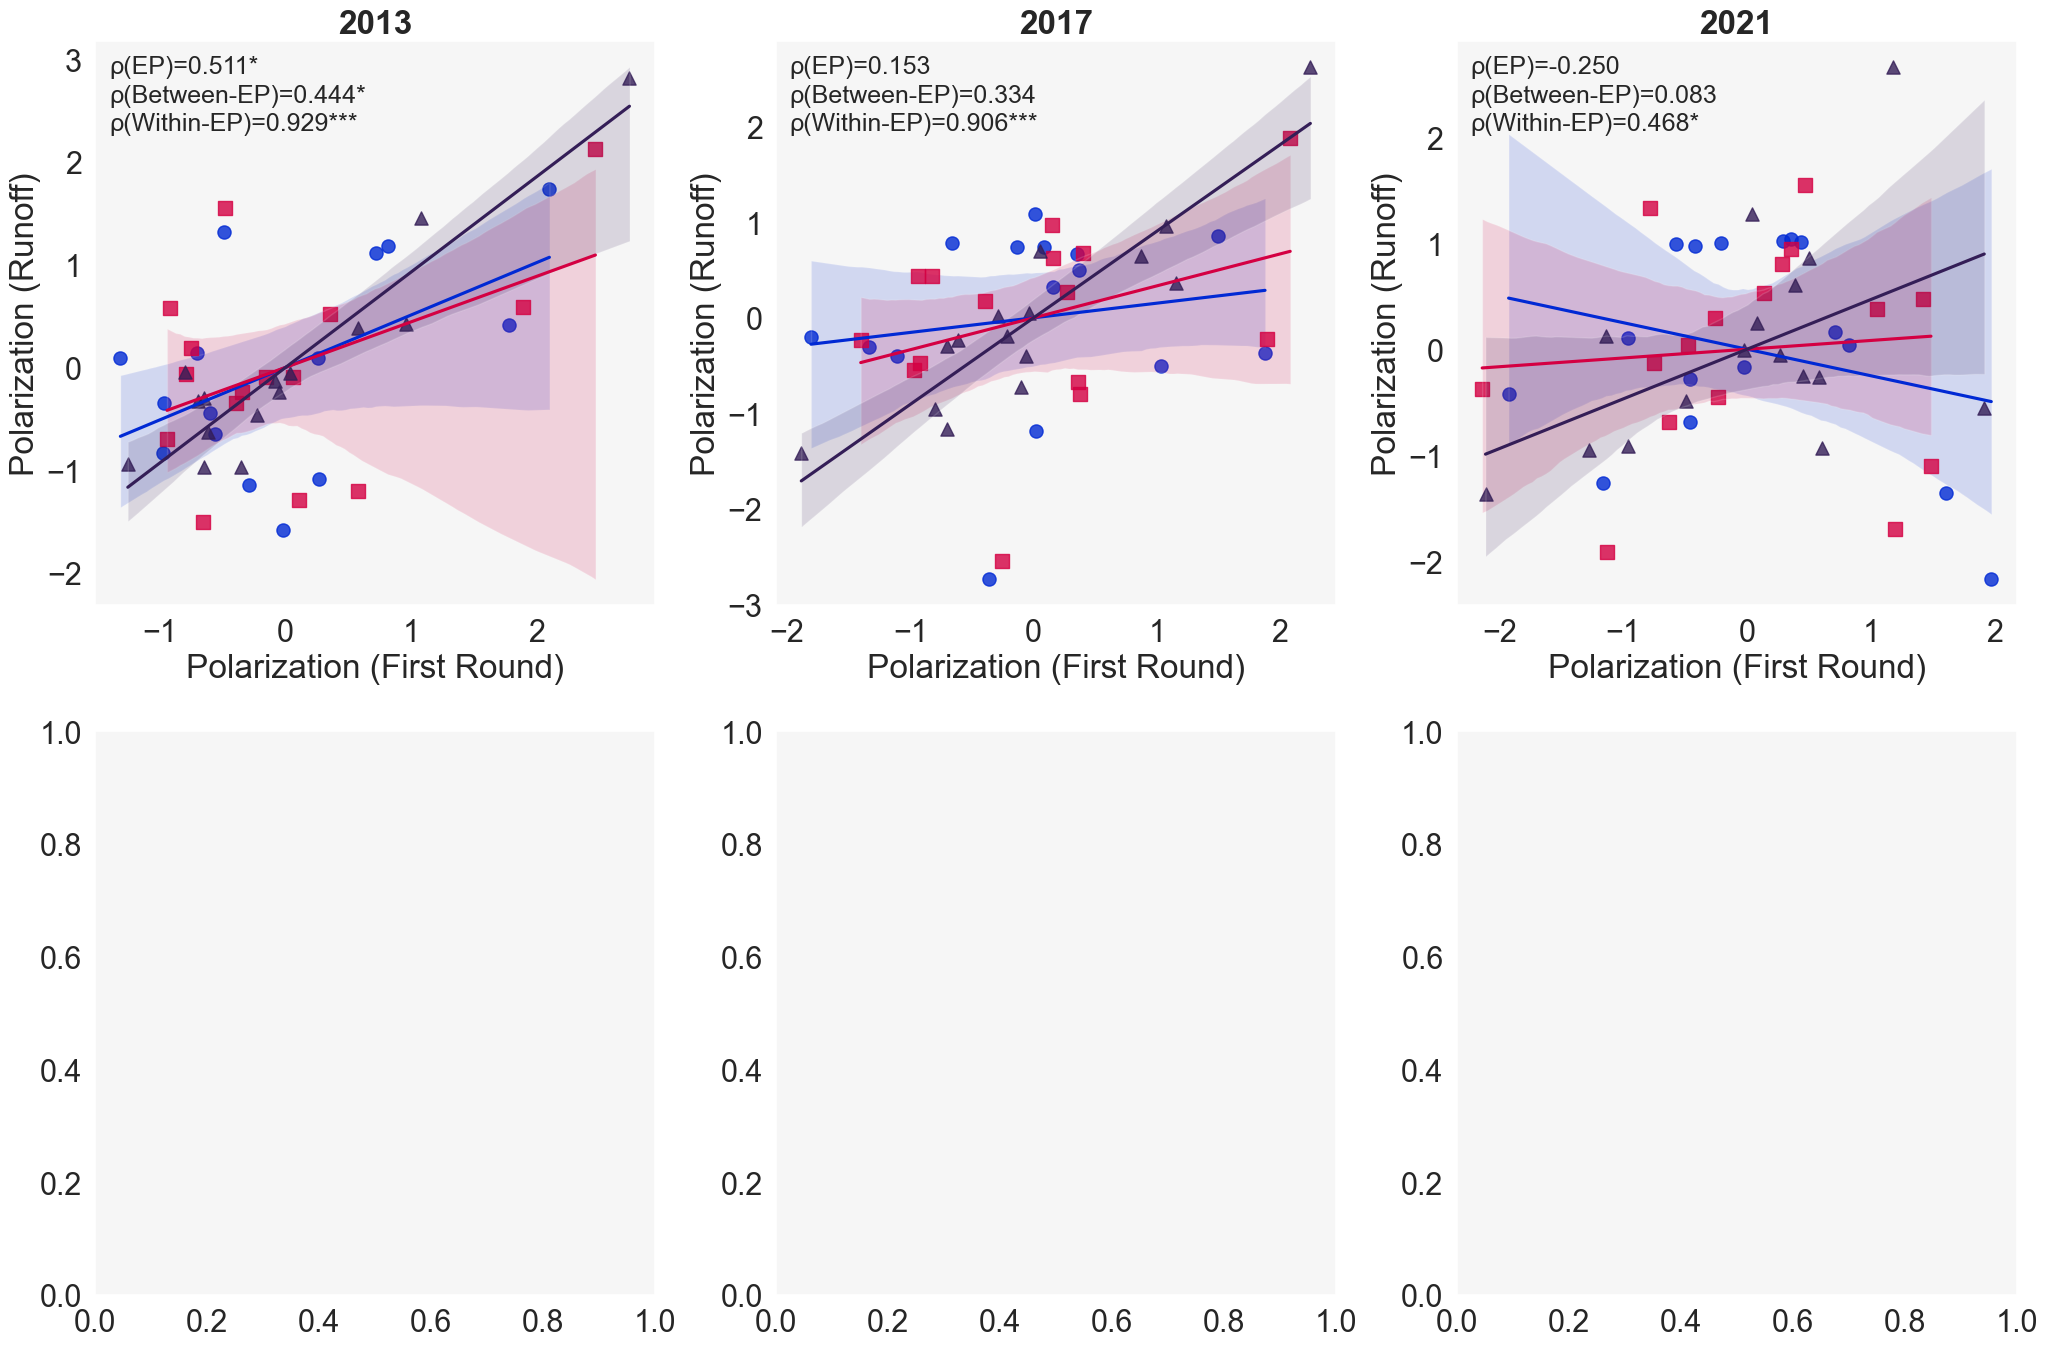

In [46]:
# 
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(21, 14))
idx = 0
for year, dt in data.groupby("year"):
    ax = axs[int(idx/3), idx%3]
    for item in [
        (dt[dt["type"] == "epi"], "#0029D4", "o"),
        (dt[dt["type"] == "epi_between"], "#D40042", "s"),
        (dt[dt["type"] == "epi_within"], "#341E57", "^")
    ]:
        g = sns.regplot(
            x="x",  y="y", 
            # hue="type", 
            #hue_order=["epi", "epi_between", "epi_within"], 
            #markers=["o", "s", "^"], 
            marker=item[2],
            scatter_kws={"s": 90},
            # palette=["#0029D4", "#D40042", "#341E57"], 
            # legend=False,
            color=item[1],
            data=item[0], 
            ax=ax
            # height=7
        )
    idx += 1

    ax.set_xlabel("Polarization (First Round)")
    ax.set_ylabel("Polarization (Runoff)")
    ax.set_title(year, fontweight=700)

    pos = 0.975
    for i, dd in dt.groupby("type"):
        corr, pvalue = pearsonr(dd["x"], dd["y"])
        def corrfunc(corr, pvalue, label):
            ax = plt.gca()
            note = ""
            if pvalue < 0.001:
                note = "***"
            elif pvalue < 0.05:
                note = "**"
            elif pvalue < 0.1:
                note = "*"

            return f"ρ({label})=" + "{:.3f}{}".format(corr, note)
        labels = {"epi": "EP", "epi_between": "Between-EP", "epi_within": "Within-EP"}
        val = corrfunc(corr, pvalue, labels[i])
        ax.text(0.025, pos, val, transform=ax.transAxes, va="top", fontsize=18)
        pos -= 0.05

fig.tight_layout()